In [1]:
import numpy as np
import pandas as pd
import cv2

# 将图片编码为rle格式
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 将rle格式进行解码为图片
def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [2]:
train_mask = pd.read_csv('./data/train_mask.csv', sep='\t', names=['name', 'mask'])

# 读取第一张图，并将对于的rle解码为mask矩阵
img = cv2.imread('./data/train/'+ train_mask['name'].iloc[0])
mask = rle_decode(train_mask['mask'].iloc[0])

print(rle_encode(mask) == train_mask['mask'].iloc[0])
# 结果为True

True


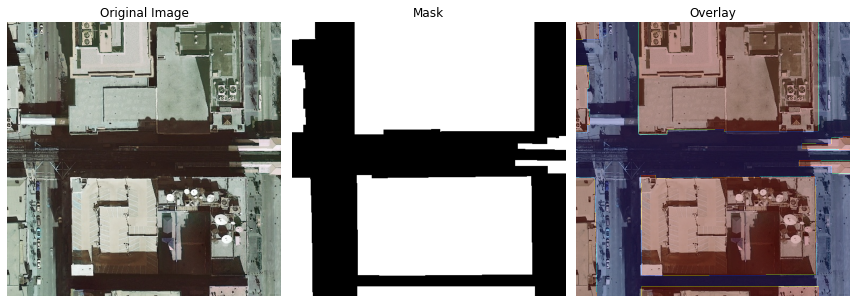

In [3]:
import matplotlib.pyplot as plt

# 读取第一张图和对应的mask
train_mask = pd.read_csv('./data/train_mask.csv', sep='\t', names=['name', 'mask'])
img = cv2.imread('./data/train/'+ train_mask['name'].iloc[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = rle_decode(train_mask['mask'].iloc[0])

# 创建可视化
plt.figure(figsize=(12, 6))

# 显示原图
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# 显示mask
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

# 显示叠加效果
plt.subplot(1, 3, 3)
plt.imshow(img)
plt.imshow(mask, alpha=0.3, cmap='jet')
plt.title('Overlay')
plt.axis('off')

plt.tight_layout()
plt.show()

## 数据集划分（8:2）

In [4]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 设置路径
data_dir = './data/data1'
train_dir = './data/train'
test_dir = './data/test'
label_file = './data/train_mask.csv'
train_label_file = './data/train.csv'
test_label_file = './data/test.csv'

# 创建目录
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# 读取标签文件
labels = pd.read_csv(label_file, sep='\t', names=['name', 'mask'])

# 获取所有图片文件名
image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]

# 划分训练集和测试集 (8:2)
train_files, test_files = train_test_split(
    image_files, 
    test_size=0.2, 
    random_state=42
)

print('正在复制训练集图片...')
for file in tqdm(train_files, desc='复制训练集'):
    shutil.copy(os.path.join(data_dir, file), os.path.join(train_dir, file))

print('正在复制测试集图片...')
for file in tqdm(test_files, desc='复制测试集'):
    shutil.copy(os.path.join(data_dir, file), os.path.join(test_dir, file))

# 生成训练集标签文件
train_labels = labels[labels['name'].isin(train_files)]
train_labels.to_csv(train_label_file, sep='\t', index=False, header=False)

# 生成测试集标签文件
test_labels = labels[labels['name'].isin(test_files)]
test_labels.to_csv(test_label_file, sep='\t', index=False, header=False)

print(f'\n数据集划分完成！训练集: {len(train_files)}张, 测试集: {len(test_files)}张')
print(f'训练集标签文件: {train_label_file}')
print(f'测试集标签文件: {test_label_file}')

正在复制训练集图片...


复制训练集: 100%|██████████| 24000/24000 [17:00<00:00, 23.51it/s]  


正在复制测试集图片...


复制测试集: 100%|██████████| 6000/6000 [03:44<00:00, 26.72it/s]



数据集划分完成！训练集: 24000张, 测试集: 6000张
训练集标签文件: ./data/train.csv
测试集标签文件: ./data/test.csv
